<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Network_dependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
dataframe_dir  = os.path.join(data_dir, "dataframe")
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 261 (delta 38), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (261/261), 29.94 MiB | 26.99 MiB/s, done.
Resolving deltas: 100% (79/79), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [ ]:
import pandas as pd
import pickle
path = os.path.join(dataframe_dir, "dataframe.pkl")
with open(path, "rb") as f:
    df = pickle.load(f)

In [ ]:
df

,sid,roi,responsiveness,predictability,principal_gradient,5HT4_sb20_hc59_beliveau.csv,5HT6_gsk_hc30_radhakrishnan.csv,A4B2_flubatine_hc30_hillmer.csv,D1_SCH23390_hc13_kaller.csv,H3_cban_hc8_gallezot.csv,...,D2,DAT,GABA,MU,Vacht,mGluR5,rsn_name,rsn_id,SC_strength,SC_centrality
0,id_100206,0,0.000436,-0.494759,-0.050580,1.973089,0.327083,9.928139,19.084266,16.457528,...,5.356258,15.261758,430.890511,6.298222,8.197274,2.305908,Vis,1,37161.546875,0.048194
1,id_100206,1,0.000615,-0.401189,0.010453,2.145067,0.385849,9.480640,18.276535,16.161533,...,5.881867,16.367297,423.358869,6.395766,8.741163,2.398924,Vis,1,50868.304688,0.066174
2,id_100206,2,0.000378,-0.471682,-0.021947,1.868203,0.369909,10.301394,14.429312,16.414764,...,5.376932,14.629332,431.931700,5.998399,8.214840,2.244107,Vis,1,32609.529297,0.044430
3,id_100206,3,0.000418,-0.361711,-0.061103,2.031370,0.403947,10.027803,17.679196,15.466934,...,5.537070,14.750274,474.282215,5.033700,8.293421,2.268144,Vis,1,43413.921875,0.056582
4,id_100206,4,0.000393,-0.433977,-0.052287,1.895362,0.405218,10.131259,15.705146,15.586376,...,5.408098,14.986570,467.329135,5.226217,8.162037,2.156322,Vis,1,38693.851562,0.052386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,id_102311,395,0.000343,-0.261130,0.081276,2.458207,0.633266,10.650736,20.157903,19.536787,...,5.931734,14.548252,501.267849,9.183700,8.920820,2.634031,Default,7,26607.945312,0.036930
3996,id_102311,396,0.000278,-0.410756,0.064631,2.521605,0.426852,10.556403,21.477304,16.774457,...,5.747677,15.349130,476.006128,6.027745,9.710948,2.572364,Default,7,29410.484375,0.038255
3997,id_102311,397,0.000322,-0.302693,0.045924,2.532997,0.324955,10.753576,21.422412,19.354674,...,5.609310,15.493046,475.749008,5.029901,11.443817,2.672199,Default,7,22625.402344,0.029176
3998,id_102311,398,0.000249,-0.255351,0.116929,2.423518,0.475818,10.452027,17.906608,17.443165,...,5.898482,15.080128,409.934983,6.857846,9.260916,2.501125,Default,7,30293.156250,0.040341


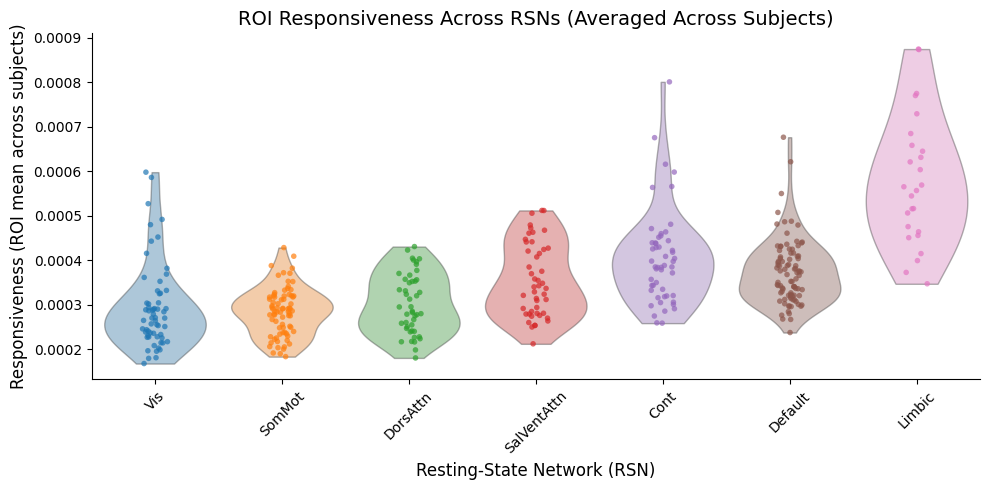

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Average responsiveness across subjects per ROI
df_roi_mean = (
    df.groupby(['roi', 'rsn_name'], as_index=False)
      .agg({'responsiveness': 'mean'})
)

# 2. Order RSNs according to cortical hierarchy
rsn_order = ["Vis", "SomMot", "DorsAttn", "SalVentAttn",
             "Cont", "Default", "Limbic"]  # change if you prefer a different hierarchy

# 3. Define a color for each RSN
base_colors = sns.color_palette("tab10", n_colors=len(rsn_order))
rsn_palette = {rsn: c for rsn, c in zip(rsn_order, base_colors)}

# 4. Plot
plt.figure(figsize=(10, 5))

# Violin plot: one violin per RSN, colored by RSN
sns.violinplot(
    data=df_roi_mean,
    x="rsn_name",
    y="responsiveness",
    order=rsn_order,
    hue="rsn_name",
    hue_order=rsn_order,
    palette=rsn_palette,
    inner=None,
    cut=0,
    dodge=False,
    linewidth=1,
    alpha=0.4
)

# Points: each ROI (mean across subjects), matching RSN color
sns.stripplot(
    data=df_roi_mean,
    x="rsn_name",
    y="responsiveness",
    order=rsn_order,
    hue="rsn_name",
    hue_order=rsn_order,
    palette=rsn_palette,
    dodge=False,
    size=4,
    jitter=True,
    alpha=0.7
)

plt.xlabel("Resting-State Network (RSN)", fontsize=12)
plt.ylabel("Responsiveness (ROI mean across subjects)", fontsize=12)
plt.title("ROI Responsiveness Across RSNs (Averaged Across Subjects)", fontsize=14)
plt.xticks(rotation=45)

# Remove duplicate legend (violin + strip) or hide legend entirely if not needed
#plt.legend_.remove()

sns.despine()
plt.tight_layout()
plt.show()


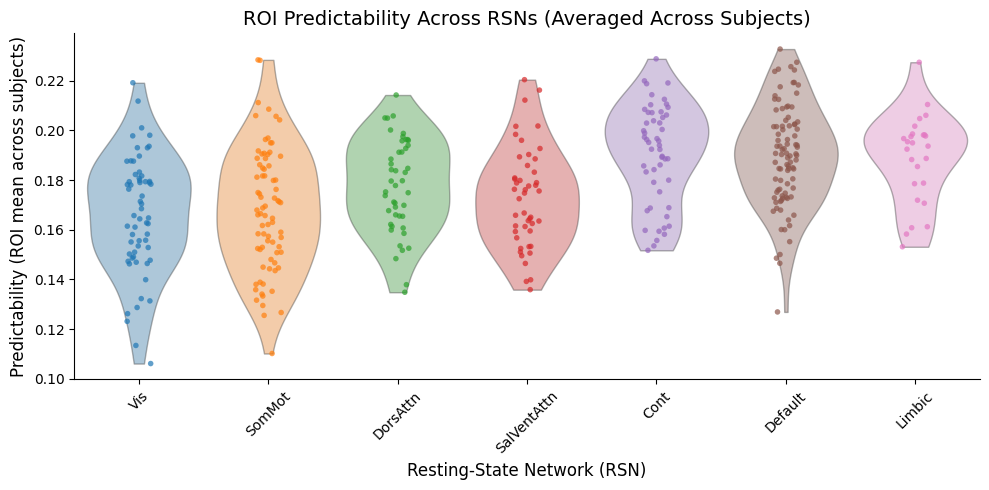

In [ ]:
# 1. Average predictability across subjects per ROI
df_roi_mean = (
    df.groupby(['roi', 'rsn_name'], as_index=False)
      .agg({'predictability': 'mean'})
)

# Square the mean predictability per ROI
df_roi_mean["predictability_sq"] = df_roi_mean["predictability"] ** 2

# 2. Order RSNs according to cortical hierarchy
rsn_order = ["Vis", "SomMot", "DorsAttn", "SalVentAttn",
             "Cont", "Default", "Limbic"]  # change if you prefer a different hierarchy

# 3. Define a color for each RSN
base_colors = sns.color_palette("tab10", n_colors=len(rsn_order))
rsn_palette = {rsn: c for rsn, c in zip(rsn_order, base_colors)}

# 4. Plot
plt.figure(figsize=(10, 5))

# Violin plot: one violin per RSN, colored by RSN
sns.violinplot(
    data=df_roi_mean,
    x="rsn_name",
    y="predictability_sq",
    order=rsn_order,
    hue="rsn_name",
    hue_order=rsn_order,
    palette=rsn_palette,
    inner=None,
    cut=0,
    dodge=False,
    linewidth=1,
    alpha=0.4
)

# Points: each ROI (mean across subjects), matching RSN color
sns.stripplot(
    data=df_roi_mean,
    x="rsn_name",
    y="predictability_sq",
    order=rsn_order,
    hue="rsn_name",
    hue_order=rsn_order,
    palette=rsn_palette,
    dodge=False,
    size=4,
    jitter=True,
    alpha=0.7
)

plt.xlabel("Resting-State Network (RSN)", fontsize=12)
plt.ylabel("Predictability (ROI mean across subjects)", fontsize=12)
plt.title("ROI Predictability Across RSNs (Averaged Across Subjects)", fontsize=14)
plt.xticks(rotation=45)

# Remove duplicate legend (violin + strip) or hide legend entirely if not needed
# plt.legend_.remove()

sns.despine()
plt.tight_layout()
plt.show()
